### House Sales in King County, USA

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import optuna

In [3]:
# Load the CSV file
file_path = "C:/Users/pooji/Downloads/washington_housing_prices.csv"
df = pd.read_csv(file_path)

print(df.head())

                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

In [ ]:
df.info()

In [5]:
df[['State', 'ZIP']] = df['statezip'].str.split(' ', expand=True)

# Convert ZIP to integer if needed
df['ZIP'] = df['ZIP'].astype(int)

In [6]:
df.drop(columns=['date', 'street', 'statezip', 'State', 'country'], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   float64
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  city           4600 non-null   object 
 14  ZIP            4600 non-null   int32  
dtypes: float64(4), int32(1), int64(9), object(1)
memory usage: 521.2+ KB


In [8]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [9]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for future use

# Display final data info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   float64
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  city           4600 non-null   int32  
 14  ZIP            4600 non-null   int32  
dtypes: float64(4), int32(2), int64(9)
memory usage: 503.3 KB
None
       price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  

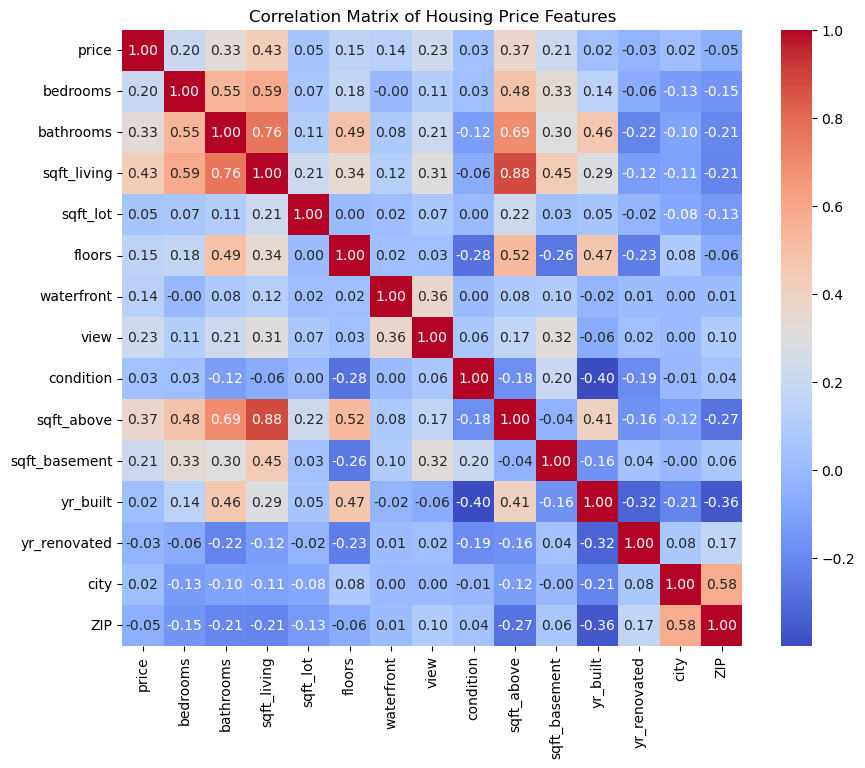

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Housing Price Features')
plt.show()

In [11]:
# Define the features (X) and target (y)
X = df.drop(['price'],axis=1)
y = df['price']

In [12]:
def generate_seeds(base_number, count=5):
    random.seed(base_number)  # Set base seed for reproducibility
    return [random.randint(0, 10**9) for _ in range(count)]  # Generate 5 random seeds

base_number = 297699  # Example input
seed_values = generate_seeds(base_number)
print(seed_values)

[459730947, 705232101, 276481090, 107708565, 415652849]


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = base_number)

Model 1: Random Forest Regressor

In [15]:
# ------------------------
# Baseline with RandomForest (Polynomial Features)
# ------------------------
rf_model_baseline = RandomForestRegressor(random_state = base_number)
rf_model_baseline.fit(X_train, y_train)
y_pred_baseline = rf_model_baseline.predict(X_test)
r2_rf = r2_score(y_test, y_pred_baseline)
print(f"Random Forest R² Score for Baseline model: {r2_rf:.4f}")

# ------------------------
# Feature Selection with RandomForest (Polynomial Features)
# ------------------------
selector = SelectKBest(score_func=f_regression, k=10)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)
rf_model_fs = RandomForestRegressor(random_state = base_number)
rf_model_fs.fit(X_train_fs, y_train)
y_pred_fs = rf_model_fs.predict(X_test_fs)
r2_rf = r2_score(y_test, y_pred_fs)
print(f"Random Forest R² Score for Feature Selection model: {r2_rf:.4f}")

# ------------------------
# Feature Engineering with RandomForest (Polynomial Features)
# ------------------------
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_fe = poly.fit_transform(X_train)
X_test_fe = poly.transform(X_test)
rf_model_fe = RandomForestRegressor(random_state = base_number)
rf_model_fe.fit(X_train_fe, y_train)
y_pred_fe = rf_model_fe.predict(X_test_fe)
r2_rf = r2_score(y_test, y_pred_fe)
print(f"Random Forest R² Score for Feature Engineering model: {r2_rf:.4f}")

Random Forest R² Score for Baseline model: 0.2532
Random Forest R² Score for Feature Selection model: -0.3635
Random Forest R² Score for Feature Engineering model: -0.0719


In [16]:
# Since Baseline Random Forest is the best model, we optimize on that model
def objective(trial, seed):

    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features = max_features,
        random_state=seed
    )

    # Perform cross-validation and calculate R2 scores
    kf = KFold(n_splits=5, shuffle=True, random_state = seed)


    # Perform cross-validation and calculate R2 scores
    R2_scores = []
    for train_index, val_index in kf.split(X_train):
      x_train_fold, x_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
      model.fit(x_train_fold, y_train_fold)
      y_pred_fold = model.predict(x_val_fold)
      R2_scores.append(r2_score(y_val_fold, y_pred_fold))
    return np.mean(R2_scores) # Return average R2 across folds


In [17]:
best_seed = None
best_study = None
best_r2_score = float('-inf')

for seed in seed_values:
    print(f"\n Running optimization for seed: {seed}")
    
    # Create Optuna study to maximize R² score
    study = optuna.create_study(direction='maximize')
    
    # Optimize the objective function while passing the current seed
    study.optimize(lambda trial: objective(trial, seed), n_trials=20)

    # Check if the current seed produced the best R² score
    if study.best_value > best_r2_score:
        best_r2_score = study.best_value
        best_seed = seed
        best_study = study  # Store the best study object

[I 2025-02-18 19:16:11,667] A new study created in memory with name: no-name-6e12d8ca-0755-4c5a-b34d-d03146345537



 Running optimization for seed: 459730947


[I 2025-02-18 19:16:20,493] Trial 0 finished with value: 0.24664691028462465 and parameters: {'n_estimators': 189, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 10}. Best is trial 0 with value: 0.24664691028462465.
[I 2025-02-18 19:16:25,551] Trial 1 finished with value: 0.29257301858272583 and parameters: {'n_estimators': 157, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 10}. Best is trial 1 with value: 0.29257301858272583.
[I 2025-02-18 19:16:26,875] Trial 2 finished with value: 0.41415766344295274 and parameters: {'n_estimators': 89, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 2}. Best is trial 2 with value: 0.41415766344295274.
[I 2025-02-18 19:16:28,486] Trial 3 finished with value: 0.2173095473133153 and parameters: {'n_estimators': 68, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 9}. Best is trial 2 with value: 0.41415766344295274.
[I 2025-02-


 Running optimization for seed: 705232101


[I 2025-02-18 19:17:28,250] Trial 0 finished with value: 0.36615089318504807 and parameters: {'n_estimators': 179, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 2}. Best is trial 0 with value: 0.36615089318504807.
[I 2025-02-18 19:17:30,840] Trial 1 finished with value: 0.36721020450868974 and parameters: {'n_estimators': 104, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 4}. Best is trial 1 with value: 0.36721020450868974.
[I 2025-02-18 19:17:35,512] Trial 2 finished with value: 0.368785087604954 and parameters: {'n_estimators': 176, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 5}. Best is trial 2 with value: 0.368785087604954.
[I 2025-02-18 19:17:39,537] Trial 3 finished with value: 0.37008383808110873 and parameters: {'n_estimators': 175, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 4}. Best is trial 3 with value: 0.37008383808110873.
[I 2025-02-1


 Running optimization for seed: 276481090


[I 2025-02-18 19:19:01,693] Trial 0 finished with value: 0.34727152350247065 and parameters: {'n_estimators': 59, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 9}. Best is trial 0 with value: 0.34727152350247065.
[I 2025-02-18 19:19:06,984] Trial 1 finished with value: 0.3766084789799223 and parameters: {'n_estimators': 186, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 6}. Best is trial 1 with value: 0.3766084789799223.
[I 2025-02-18 19:19:08,337] Trial 2 finished with value: 0.3673916901897281 and parameters: {'n_estimators': 55, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 5}. Best is trial 1 with value: 0.3766084789799223.
[I 2025-02-18 19:19:13,139] Trial 3 finished with value: 0.3468443553990005 and parameters: {'n_estimators': 88, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 13}. Best is trial 1 with value: 0.3766084789799223.
[I 2025-02-18 19:


 Running optimization for seed: 107708565


[I 2025-02-18 19:20:28,215] Trial 0 finished with value: 0.295193405995058 and parameters: {'n_estimators': 144, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 1}. Best is trial 0 with value: 0.295193405995058.
[I 2025-02-18 19:20:30,706] Trial 1 finished with value: 0.33703885895555635 and parameters: {'n_estimators': 59, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 9}. Best is trial 1 with value: 0.33703885895555635.
[I 2025-02-18 19:20:37,112] Trial 2 finished with value: 0.26716335903458666 and parameters: {'n_estimators': 112, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 9}. Best is trial 1 with value: 0.33703885895555635.
[I 2025-02-18 19:20:40,126] Trial 3 finished with value: 0.3334705528445074 and parameters: {'n_estimators': 129, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 5}. Best is trial 1 with value: 0.33703885895555635.
[I 2025-02-18 19


 Running optimization for seed: 415652849


[I 2025-02-18 19:21:28,455] Trial 0 finished with value: 0.37692051473854604 and parameters: {'n_estimators': 107, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 2}. Best is trial 0 with value: 0.37692051473854604.
[I 2025-02-18 19:21:32,606] Trial 1 finished with value: 0.26869288154831017 and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 13}. Best is trial 0 with value: 0.37692051473854604.
[I 2025-02-18 19:21:38,668] Trial 2 finished with value: 0.3748229835509568 and parameters: {'n_estimators': 173, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 9}. Best is trial 0 with value: 0.37692051473854604.
[I 2025-02-18 19:21:41,745] Trial 3 finished with value: 0.371218364639461 and parameters: {'n_estimators': 179, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 2}. Best is trial 0 with value: 0.37692051473854604.
[I 2025-02-

In [18]:
# Print the best results
print("\n Best Overall Result:")
print(f"Best Seed: {best_seed}")
print(f"Best R² Score: {best_r2_score:.4f}")
print(f"Best Hyperparameters: {best_study.best_params}")


 Best Overall Result:
Best Seed: 459730947
Best R² Score: 0.4311
Best Hyperparameters: {'n_estimators': 104, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 5}


In [19]:
# ------------------------
# Baseline XGBoost Model
# ------------------------
xgb_model_baseline = xgb.XGBRegressor(random_state=base_number, objective='reg:squarederror')
xgb_model_baseline.fit(X_train, y_train)
y_pred_baseline = xgb_model_baseline.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_baseline)
print(f"XGBoost R² Score for Baseline model: {r2_xgb:.4f}")

# ------------------------
# Feature Selection with XGBoost
# ------------------------
selector = SelectKBest(score_func=f_regression, k=10)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)
xgb_model_fs = xgb.XGBRegressor(random_state=base_number, objective='reg:squarederror')
xgb_model_fs.fit(X_train_fs, y_train)
y_pred_fs = xgb_model_fs.predict(X_test_fs)
r2_xgb = r2_score(y_test, y_pred_fs)
print(f"XGBoost R² Score for Feature Selection model: {r2_xgb:.4f}")

# ------------------------
# Feature Engineering with XGBoost (Polynomial Features)
# ------------------------
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_fe = poly.fit_transform(X_train)
X_test_fe = poly.transform(X_test)
xgb_model_fe = xgb.XGBRegressor(random_state=base_number, objective='reg:squarederror')
xgb_model_fe.fit(X_train_fe, y_train)
y_pred_fe = xgb_model_fe.predict(X_test_fe)
r2_xgb = r2_score(y_test, y_pred_fe)
print(f"XGBoost R² Score for Feature Engineering model: {r2_xgb:.4f}")

XGBoost R² Score for Baseline model: 0.0019
XGBoost R² Score for Feature Selection model: -2.0654
XGBoost R² Score for Feature Engineering model: -2.2721


In [20]:
# Since Baseline XGBoost is the best model, we optimize on that model
def objective(trial, seed):

    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Number of boosting rounds
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Maximum depth of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Learning rate
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Row sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature sampling per tree
        'gamma': trial.suggest_float('gamma', 0, 5),  # Minimum loss reduction required to split
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # L2 regularization
        'random_state': seed
    }

    # Initialize XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', **params)

    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    R2_scores = []
    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(x_train_fold, y_train_fold)
        y_pred_fold = model.predict(x_val_fold)
        R2_scores.append(r2_score(y_val_fold, y_pred_fold))

    return np.mean(R2_scores)  # Return the average R² across folds

In [21]:
# Track the best seed and result
best_seed = None
best_study = None
best_r2_score = float('-inf')

# Run Optuna optimization for each seed
for seed in seed_values:
    print(f"\n Running optimization for seed: {seed}")
    
    # Create Optuna study to maximize R² score
    study = optuna.create_study(direction='maximize')
    
    # Optimize the objective function while passing the current seed
    study.optimize(lambda trial: objective(trial, seed), n_trials=20)

    # Check if the current seed produced the best R² score
    if study.best_value > best_r2_score:
        best_r2_score = study.best_value
        best_seed = seed
        best_study = study  # Store the best study object

[I 2025-02-18 19:22:35,166] A new study created in memory with name: no-name-a843e6c8-ace6-4420-b58b-d6948617f4df



 Running optimization for seed: 459730947


[I 2025-02-18 19:22:39,503] Trial 0 finished with value: 0.21364919707593616 and parameters: {'n_estimators': 157, 'max_depth': 14, 'learning_rate': 0.050752971805649486, 'subsample': 0.6920173245578124, 'colsample_bytree': 0.9227957019821645, 'gamma': 3.3574346197231635, 'reg_alpha': 9.860716783611505, 'reg_lambda': 9.336688121602227}. Best is trial 0 with value: 0.21364919707593616.
[I 2025-02-18 19:22:39,924] Trial 1 finished with value: 0.20812506760963095 and parameters: {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.11890361706118704, 'subsample': 0.9751423172164282, 'colsample_bytree': 0.8960227597005725, 'gamma': 1.1224601550666202, 'reg_alpha': 2.9449061736236737, 'reg_lambda': 6.985557040245221}. Best is trial 0 with value: 0.21364919707593616.
[I 2025-02-18 19:22:40,800] Trial 2 finished with value: 0.4030793426735241 and parameters: {'n_estimators': 259, 'max_depth': 3, 'learning_rate': 0.03430999441305971, 'subsample': 0.6217067883698462, 'colsample_bytree': 0.67


 Running optimization for seed: 705232101


[I 2025-02-18 19:23:46,810] Trial 0 finished with value: 0.2831132881285572 and parameters: {'n_estimators': 90, 'max_depth': 11, 'learning_rate': 0.010608667293125726, 'subsample': 0.8144858547046068, 'colsample_bytree': 0.6745799803332013, 'gamma': 0.6332455611085724, 'reg_alpha': 3.0009819482057964, 'reg_lambda': 9.934259339572383}. Best is trial 0 with value: 0.2831132881285572.
[I 2025-02-18 19:23:49,792] Trial 1 finished with value: 0.24128235010727178 and parameters: {'n_estimators': 111, 'max_depth': 14, 'learning_rate': 0.18521423486664562, 'subsample': 0.768314399786288, 'colsample_bytree': 0.9103238211097306, 'gamma': 4.587327237219136, 'reg_alpha': 2.6939041631239737, 'reg_lambda': 9.628374252356162}. Best is trial 0 with value: 0.2831132881285572.
[I 2025-02-18 19:23:53,967] Trial 2 finished with value: 0.3465285545599274 and parameters: {'n_estimators': 117, 'max_depth': 13, 'learning_rate': 0.028983614486525297, 'subsample': 0.962521694730496, 'colsample_bytree': 0.79727


 Running optimization for seed: 276481090


[I 2025-02-18 19:24:48,692] Trial 0 finished with value: 0.09760682772934096 and parameters: {'n_estimators': 188, 'max_depth': 6, 'learning_rate': 0.29169466483556156, 'subsample': 0.5992256879648448, 'colsample_bytree': 0.5856557230057029, 'gamma': 0.9958445725976678, 'reg_alpha': 6.23087779497001, 'reg_lambda': 1.7577754054303996}. Best is trial 0 with value: 0.09760682772934096.
[I 2025-02-18 19:24:53,372] Trial 1 finished with value: 0.39603517771328095 and parameters: {'n_estimators': 181, 'max_depth': 15, 'learning_rate': 0.026137533558882597, 'subsample': 0.6353684004458007, 'colsample_bytree': 0.6138931658378259, 'gamma': 1.267311204788979, 'reg_alpha': 4.7085539883141205, 'reg_lambda': 9.68572569408567}. Best is trial 1 with value: 0.39603517771328095.
[I 2025-02-18 19:24:58,858] Trial 2 finished with value: 0.13787363142546163 and parameters: {'n_estimators': 178, 'max_depth': 13, 'learning_rate': 0.28344383345479685, 'subsample': 0.823623438540393, 'colsample_bytree': 0.664


 Running optimization for seed: 107708565


[I 2025-02-18 19:25:28,099] Trial 0 finished with value: 0.16545140567165378 and parameters: {'n_estimators': 241, 'max_depth': 6, 'learning_rate': 0.03859103147845874, 'subsample': 0.7659805927955627, 'colsample_bytree': 0.770046105565058, 'gamma': 1.4270381404670025, 'reg_alpha': 4.944429914500022, 'reg_lambda': 1.3829510244569176}. Best is trial 0 with value: 0.16545140567165378.
[I 2025-02-18 19:25:33,193] Trial 1 finished with value: 0.3035808777435137 and parameters: {'n_estimators': 205, 'max_depth': 13, 'learning_rate': 0.03070062048627498, 'subsample': 0.8341453603586195, 'colsample_bytree': 0.6532018092670232, 'gamma': 4.692264862835937, 'reg_alpha': 6.484952527158293, 'reg_lambda': 8.169931346392202}. Best is trial 1 with value: 0.3035808777435137.
[I 2025-02-18 19:25:41,516] Trial 2 finished with value: 0.013796058074929562 and parameters: {'n_estimators': 283, 'max_depth': 15, 'learning_rate': 0.03704759590079018, 'subsample': 0.6609127235530186, 'colsample_bytree': 0.9230


 Running optimization for seed: 415652849


[I 2025-02-18 19:26:24,996] Trial 0 finished with value: 0.3544500199061823 and parameters: {'n_estimators': 157, 'max_depth': 7, 'learning_rate': 0.011669656554081576, 'subsample': 0.6929757954827795, 'colsample_bytree': 0.7651478758474388, 'gamma': 3.9869710659625284, 'reg_alpha': 6.769672009608526, 'reg_lambda': 8.726589489578316}. Best is trial 0 with value: 0.3544500199061823.
[I 2025-02-18 19:26:26,317] Trial 1 finished with value: -0.004752523563512611 and parameters: {'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.07787094071089463, 'subsample': 0.8365613626205379, 'colsample_bytree': 0.7420765018034852, 'gamma': 2.507084157260557, 'reg_alpha': 8.264910803488236, 'reg_lambda': 8.218087223545087}. Best is trial 0 with value: 0.3544500199061823.
[I 2025-02-18 19:26:27,249] Trial 2 finished with value: 0.3499803381819162 and parameters: {'n_estimators': 273, 'max_depth': 4, 'learning_rate': 0.03015578654419221, 'subsample': 0.6390728725089353, 'colsample_bytree': 0.599336

In [22]:
# Print the best results
print("\n Best Overall Result:")
print(f"Best Seed: {best_seed}")
print(f"Best R² Score: {best_r2_score:.4f}")
print(f"Best Hyperparameters: {best_study.best_params}")


 Best Overall Result:
Best Seed: 459730947
Best R² Score: 0.4442
Best Hyperparameters: {'n_estimators': 237, 'max_depth': 12, 'learning_rate': 0.01799647120343438, 'subsample': 0.7981573474590907, 'colsample_bytree': 0.5134697114607423, 'gamma': 2.6393478834557573, 'reg_alpha': 8.040417007487935, 'reg_lambda': 7.6618097068657}


In [23]:
# ------------------------
# Baseline Gradient Boosting Model
# ------------------------
gb_model_baseline = GradientBoostingRegressor(random_state=base_number)
gb_model_baseline.fit(X_train, y_train)
y_pred_baseline = gb_model_baseline.predict(X_test)
r2_gb = r2_score(y_test, y_pred_baseline)
print(f"Gradient Boosting R² Score for Baseline model: {r2_gb:.4f}")

# ------------------------
# Feature Selection with Gradient Boosting
# ------------------------
selector = SelectKBest(score_func=f_regression, k=10)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)

gb_model_fs = GradientBoostingRegressor(random_state=base_number)
gb_model_fs.fit(X_train_fs, y_train)
y_pred_fs = gb_model_fs.predict(X_test_fs)
r2_gb_fs = r2_score(y_test, y_pred_fs)
print(f"Gradient Boosting R² Score for Feature Selection model: {r2_gb_fs:.4f}")

# ------------------------
# Feature Engineering with Gradient Boosting
# ------------------------
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_fe = poly.fit_transform(X_train)
X_test_fe = poly.transform(X_test)

gb_model_fe = GradientBoostingRegressor(random_state=base_number)
gb_model_fe.fit(X_train_fe, y_train)
y_pred_fe = gb_model_fe.predict(X_test_fe)
r2_gb_fe = r2_score(y_test, y_pred_fe)
print(f"Gradient Boosting R² Score for Feature Engineering model: {r2_gb_fe:.4f}")

Gradient Boosting R² Score for Baseline model: 0.4713
Gradient Boosting R² Score for Feature Selection model: 0.0550
Gradient Boosting R² Score for Feature Engineering model: 0.3305


In [24]:
# Since Baseline Gradient Boosting is the best model, we optimize on that model
def objective(trial, seed):

    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Number of boosting rounds
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Maximum depth of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Learning rate
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Row sampling
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  # Min samples to split a node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),  # Min samples per leaf
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),  # Feature selection per tree
        'random_state': seed
    }

    # Initialize Gradient Boosting model
    model = GradientBoostingRegressor(**params)

    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    R2_scores = []
    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(x_train_fold, y_train_fold)
        y_pred_fold = model.predict(x_val_fold)
        R2_scores.append(r2_score(y_val_fold, y_pred_fold))

    return np.mean(R2_scores)  # Return the average R² across folds

In [25]:
# Track the best seed and result
best_seed = None
best_study = None
best_r2_score = float('-inf')

# Run Optuna optimization for each seed
for seed in seed_values:
    print(f"\n Running optimization for seed: {seed}")
    
    # Create Optuna study to maximize R² score
    study = optuna.create_study(direction='maximize')
    
    # Optimize the objective function while passing the current seed
    study.optimize(lambda trial: objective(trial, seed), n_trials=20)

    # Check if the current seed produced the best R² score
    if study.best_value > best_r2_score:
        best_r2_score = study.best_value
        best_seed = seed
        best_study = study  # Store the best study object

[I 2025-02-18 19:27:12,121] A new study created in memory with name: no-name-cee6f451-12a4-4347-a505-e3ede669912c



 Running optimization for seed: 459730947


[I 2025-02-18 19:27:22,406] Trial 0 finished with value: 0.027948750845382307 and parameters: {'n_estimators': 282, 'max_depth': 8, 'learning_rate': 0.1544583206594023, 'subsample': 0.8878970354303275, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 0.6829351180270382}. Best is trial 0 with value: 0.027948750845382307.
[I 2025-02-18 19:27:29,960] Trial 1 finished with value: 0.2735351272043026 and parameters: {'n_estimators': 168, 'max_depth': 10, 'learning_rate': 0.030567267336649353, 'subsample': 0.8161629300928827, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.8418552487521478}. Best is trial 1 with value: 0.2735351272043026.
[I 2025-02-18 19:27:37,827] Trial 2 finished with value: -0.12256714432618694 and parameters: {'n_estimators': 160, 'max_depth': 12, 'learning_rate': 0.2632481061717766, 'subsample': 0.8982843692859017, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.6756530063595511}. Best is trial 1 with value: 0.273535127204


 Running optimization for seed: 705232101


[I 2025-02-18 19:28:58,357] Trial 0 finished with value: 0.31524593065394313 and parameters: {'n_estimators': 141, 'max_depth': 4, 'learning_rate': 0.020563493207718452, 'subsample': 0.7400676950641853, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.8511668624551565}. Best is trial 0 with value: 0.31524593065394313.
[I 2025-02-18 19:29:05,256] Trial 1 finished with value: 0.3089935428275407 and parameters: {'n_estimators': 258, 'max_depth': 11, 'learning_rate': 0.01731437341171944, 'subsample': 0.558870425420388, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5470905339186062}. Best is trial 0 with value: 0.31524593065394313.
[I 2025-02-18 19:29:08,656] Trial 2 finished with value: 0.29243430367756734 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.030936960515200947, 'subsample': 0.6831165648626079, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.8470228108975012}. Best is trial 0 with value: 0.3152459306539


 Running optimization for seed: 276481090


[I 2025-02-18 19:31:24,596] Trial 0 finished with value: 0.28465070920355673 and parameters: {'n_estimators': 133, 'max_depth': 6, 'learning_rate': 0.04267345575252294, 'subsample': 0.5546675587320943, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.9615088066517383}. Best is trial 0 with value: 0.28465070920355673.
[I 2025-02-18 19:31:30,159] Trial 1 finished with value: 0.2592276320698114 and parameters: {'n_estimators': 103, 'max_depth': 13, 'learning_rate': 0.04078594999475459, 'subsample': 0.9518679903385261, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.6450007427659971}. Best is trial 0 with value: 0.28465070920355673.
[I 2025-02-18 19:31:35,018] Trial 2 finished with value: 0.09836674425500735 and parameters: {'n_estimators': 129, 'max_depth': 9, 'learning_rate': 0.15205503457120062, 'subsample': 0.6364928220939021, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.96022500085551}. Best is trial 0 with value: 0.2846507092035567


 Running optimization for seed: 107708565


[I 2025-02-18 19:34:02,625] Trial 0 finished with value: 0.28358837288604943 and parameters: {'n_estimators': 266, 'max_depth': 10, 'learning_rate': 0.02182276700879782, 'subsample': 0.6542209005817885, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.9213497917866345}. Best is trial 0 with value: 0.28358837288604943.
[I 2025-02-18 19:34:09,300] Trial 1 finished with value: -0.16312993951483803 and parameters: {'n_estimators': 263, 'max_depth': 13, 'learning_rate': 0.11857708726554624, 'subsample': 0.503429397425815, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.5435152026136805}. Best is trial 0 with value: 0.28358837288604943.
[I 2025-02-18 19:34:19,574] Trial 2 finished with value: -0.01717188206649096 and parameters: {'n_estimators': 272, 'max_depth': 8, 'learning_rate': 0.13275918409245296, 'subsample': 0.7609750152826804, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.8762469272172784}. Best is trial 0 with value: 0.28358837288


 Running optimization for seed: 415652849


[I 2025-02-18 19:35:47,199] Trial 0 finished with value: -0.2665287319343709 and parameters: {'n_estimators': 182, 'max_depth': 10, 'learning_rate': 0.09695525319227911, 'subsample': 0.5193603456251916, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.6582548994080815}. Best is trial 0 with value: -0.2665287319343709.
[I 2025-02-18 19:35:54,553] Trial 1 finished with value: 0.24342226989498333 and parameters: {'n_estimators': 177, 'max_depth': 13, 'learning_rate': 0.017045470167747954, 'subsample': 0.5965730394623203, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.7773867916380397}. Best is trial 1 with value: 0.24342226989498333.
[I 2025-02-18 19:35:59,627] Trial 2 finished with value: -0.3439790709325811 and parameters: {'n_estimators': 96, 'max_depth': 10, 'learning_rate': 0.1263754245487727, 'subsample': 0.9286557148498872, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.7906617774907065}. Best is trial 1 with value: 0.243422269894

In [26]:
# Print the best results
print("\n Best Overall Result:")
print(f"Best Seed: {best_seed}")
print(f"Best R² Score: {best_r2_score:.4f}")
print(f"Best Hyperparameters: {best_study.best_params}")


 Best Overall Result:
Best Seed: 459730947
Best R² Score: 0.4251
Best Hyperparameters: {'n_estimators': 54, 'max_depth': 15, 'learning_rate': 0.043198713567843265, 'subsample': 0.506013637357196, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.6806698928547085}


In [58]:
# ------------------------
# # Baseline CatBoost Model
# ------------------------
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_seed=base_number, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
r2_cat = r2_score(y_test, y_pred_cat)
print(f"CatBoost R² Score: {r2_cat:.4f}")

# ------------------------
# Feature Selection with CatBoost Model
# ------------------------
selector = SelectKBest(score_func=f_regression, k=10)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)
gb_model_fs = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_seed=base_number, verbose=0)
gb_model_fs.fit(X_train_fs, y_train)
y_pred_fs = gb_model_fs.predict(X_test_fs)
r2_gb_fs = r2_score(y_test, y_pred_fs)
print(f"CatBoost R² Score for Feature Selection model: {r2_gb_fs:.4f}")

# ------------------------
# Feature Engineering with CatBoost Model
# ------------------------
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_fe = poly.fit_transform(X_train)
X_test_fe = poly.transform(X_test)
gb_model_fe = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_seed=base_number, verbose=0)
gb_model_fe.fit(X_train_fe, y_train)
y_pred_fe = gb_model_fe.predict(X_test_fe)
r2_gb_fe = r2_score(y_test, y_pred_fe)
print(f"CatBoost R² Score for Feature Engineering model: {r2_gb_fe:.4f}")

CatBoost R² Score: 0.5315
CatBoost R² Score for Feature Selection model: -2.2954
CatBoost R² Score for Feature Engineering model: 0.0442


In [59]:
# Since Baseline CatBoost is the best model, we optimize on that model
def objective(trial, seed):

    # Suggest hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),  # Number of boosting rounds
        'depth': trial.suggest_int('depth', 3, 12),  # Maximum depth of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Learning rate
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),  # L2 regularization
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),  # Random strength
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Subsample temperature
        'border_count': trial.suggest_int('border_count', 32, 255),  # Number of splits
        'random_seed': seed,  # Ensuring reproducibility
        'verbose': 0  # Suppress training output
    }

    # Initialize CatBoost model
    model = CatBoostRegressor(**params, loss_function='RMSE')

    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    r2_scores = []
    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(x_train_fold, y_train_fold, verbose=0)
        y_pred_fold = model.predict(x_val_fold)
        r2_scores.append(r2_score(y_val_fold, y_pred_fold))

    return np.mean(r2_scores)  # Return the average R² across folds

In [60]:
# Track the best seed and result
best_seed = None
best_study = None
best_r2_score = float('-inf')

# Run Optuna optimization for each seed
for seed in seed_values:
    print(f"\n Running optimization for seed: {seed}")
    
    # Create Optuna study to maximize R² score
    study = optuna.create_study(direction='maximize')
    
    # Optimize the objective function while passing the current seed
    study.optimize(lambda trial: objective(trial, seed), n_trials=20)

    # Check if the current seed produced the best R² score
    if study.best_value > best_r2_score:
        best_r2_score = study.best_value
        best_seed = seed
        best_study = study  # Store the best study object

[I 2025-02-18 19:43:01,344] A new study created in memory with name: no-name-7e9530b1-5eca-4992-a701-e4545e2d492a



 Running optimization for seed: 459730947


[I 2025-02-18 19:43:05,116] Trial 0 finished with value: -0.6793014437970958 and parameters: {'iterations': 819, 'depth': 3, 'learning_rate': 0.1526412979040179, 'l2_leaf_reg': 1.0518000771592608, 'random_strength': 0.06373407247277896, 'bagging_temperature': 0.320241137708974, 'border_count': 60}. Best is trial 0 with value: -0.6793014437970958.
[I 2025-02-18 19:43:11,635] Trial 1 finished with value: 0.21953130891535505 and parameters: {'iterations': 818, 'depth': 6, 'learning_rate': 0.012613816281410086, 'l2_leaf_reg': 0.06251144129964196, 'random_strength': 0.002420456457662448, 'bagging_temperature': 0.5656109753193836, 'border_count': 127}. Best is trial 1 with value: 0.21953130891535505.
[I 2025-02-18 19:43:14,191] Trial 2 finished with value: 0.3712511273592959 and parameters: {'iterations': 430, 'depth': 5, 'learning_rate': 0.01449418556104352, 'l2_leaf_reg': 8.88294117459195, 'random_strength': 0.01451614498703874, 'bagging_temperature': 0.8617429238664966, 'border_count': 20


 Running optimization for seed: 705232101


[I 2025-02-18 19:48:15,545] Trial 0 finished with value: 0.3030559069488702 and parameters: {'iterations': 580, 'depth': 8, 'learning_rate': 0.01120812998470077, 'l2_leaf_reg': 0.0103951401919799, 'random_strength': 0.33936936441604154, 'bagging_temperature': 0.5991439518107033, 'border_count': 245}. Best is trial 0 with value: 0.3030559069488702.
[I 2025-02-18 19:48:18,686] Trial 1 finished with value: 0.3179476782102933 and parameters: {'iterations': 319, 'depth': 8, 'learning_rate': 0.01238851131987173, 'l2_leaf_reg': 0.003885708473411629, 'random_strength': 0.27570986242404216, 'bagging_temperature': 0.3995718105592849, 'border_count': 53}. Best is trial 1 with value: 0.3179476782102933.
[I 2025-02-18 19:48:56,680] Trial 2 finished with value: 0.3550577655086603 and parameters: {'iterations': 345, 'depth': 11, 'learning_rate': 0.04377780014432673, 'l2_leaf_reg': 5.646369530610229, 'random_strength': 0.021685304804624505, 'bagging_temperature': 0.5280016091768962, 'border_count': 19


 Running optimization for seed: 276481090


[I 2025-02-18 19:56:35,707] Trial 0 finished with value: 0.23544608479413096 and parameters: {'iterations': 528, 'depth': 11, 'learning_rate': 0.12498617896221376, 'l2_leaf_reg': 1.6769297578742877, 'random_strength': 0.0014565272547744207, 'bagging_temperature': 0.3878481375431625, 'border_count': 76}. Best is trial 0 with value: 0.23544608479413096.
[I 2025-02-18 19:56:46,333] Trial 1 finished with value: 0.33212758823065647 and parameters: {'iterations': 310, 'depth': 10, 'learning_rate': 0.027846871582339828, 'l2_leaf_reg': 5.01623556037602, 'random_strength': 0.008641681933565468, 'bagging_temperature': 0.35252212766518876, 'border_count': 66}. Best is trial 1 with value: 0.33212758823065647.
[I 2025-02-18 19:56:49,819] Trial 2 finished with value: 0.14997932184076013 and parameters: {'iterations': 244, 'depth': 9, 'learning_rate': 0.238201510215024, 'l2_leaf_reg': 0.4367920246984218, 'random_strength': 0.3904287330375351, 'bagging_temperature': 0.7693714860576641, 'border_count':


 Running optimization for seed: 107708565


[I 2025-02-18 20:03:37,756] Trial 0 finished with value: 0.301564245928153 and parameters: {'iterations': 947, 'depth': 11, 'learning_rate': 0.07590009784610335, 'l2_leaf_reg': 0.6731244703582272, 'random_strength': 0.11027645298490882, 'bagging_temperature': 0.5708538500970057, 'border_count': 103}. Best is trial 0 with value: 0.301564245928153.
[I 2025-02-18 20:03:57,860] Trial 1 finished with value: 0.3031153497565767 and parameters: {'iterations': 359, 'depth': 10, 'learning_rate': 0.13805121807748147, 'l2_leaf_reg': 0.0070908067576868775, 'random_strength': 0.6872587297643309, 'bagging_temperature': 0.6932977186428068, 'border_count': 153}. Best is trial 1 with value: 0.3031153497565767.
[I 2025-02-18 20:04:06,523] Trial 2 finished with value: 0.20170468906599623 and parameters: {'iterations': 989, 'depth': 6, 'learning_rate': 0.03097215437117942, 'l2_leaf_reg': 0.6515070777998558, 'random_strength': 0.001216608448655559, 'bagging_temperature': 0.8708690709902077, 'border_count': 


 Running optimization for seed: 415652849


[I 2025-02-18 20:08:37,549] Trial 0 finished with value: 0.2518870885008667 and parameters: {'iterations': 527, 'depth': 9, 'learning_rate': 0.030302486205148384, 'l2_leaf_reg': 0.4493156306867072, 'random_strength': 0.024976201098475818, 'bagging_temperature': 0.010312411590808868, 'border_count': 215}. Best is trial 0 with value: 0.2518870885008667.
[I 2025-02-18 20:08:48,994] Trial 1 finished with value: 0.2544852269557877 and parameters: {'iterations': 884, 'depth': 7, 'learning_rate': 0.060858016269255036, 'l2_leaf_reg': 0.013309021392030159, 'random_strength': 1.0116879030170693, 'bagging_temperature': 0.688306163820946, 'border_count': 226}. Best is trial 1 with value: 0.2544852269557877.
[I 2025-02-18 20:08:51,908] Trial 2 finished with value: 0.02638720269142685 and parameters: {'iterations': 506, 'depth': 4, 'learning_rate': 0.04759844526059266, 'l2_leaf_reg': 0.015737214586647633, 'random_strength': 0.08313833349195741, 'bagging_temperature': 0.47485874544253615, 'border_cou

In [61]:
# Print the best results
print("\n Best Overall Result:")
print(f"Best Seed: {best_seed}")
print(f"Best R² Score: {best_r2_score:.4f}")
print(f"Best Hyperparameters: {best_study.best_params}")


 Best Overall Result:
Best Seed: 459730947
Best R² Score: 0.3918
Best Hyperparameters: {'iterations': 468, 'depth': 5, 'learning_rate': 0.010998123221623501, 'l2_leaf_reg': 6.918055809967816, 'random_strength': 0.4718459718107358, 'bagging_temperature': 0.7817074235792112, 'border_count': 194}


Of all the models ran, Catboost gives the best result.

In [66]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = base_number)

In [68]:
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_seed=base_number, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
r2_cat = r2_score(y_test, y_pred_cat)
print(f"CatBoost R² Score: {r2_cat:.4f}")

CatBoost R² Score: 0.5315


 94%|=================== | 864/920 [00:13<00:00]       

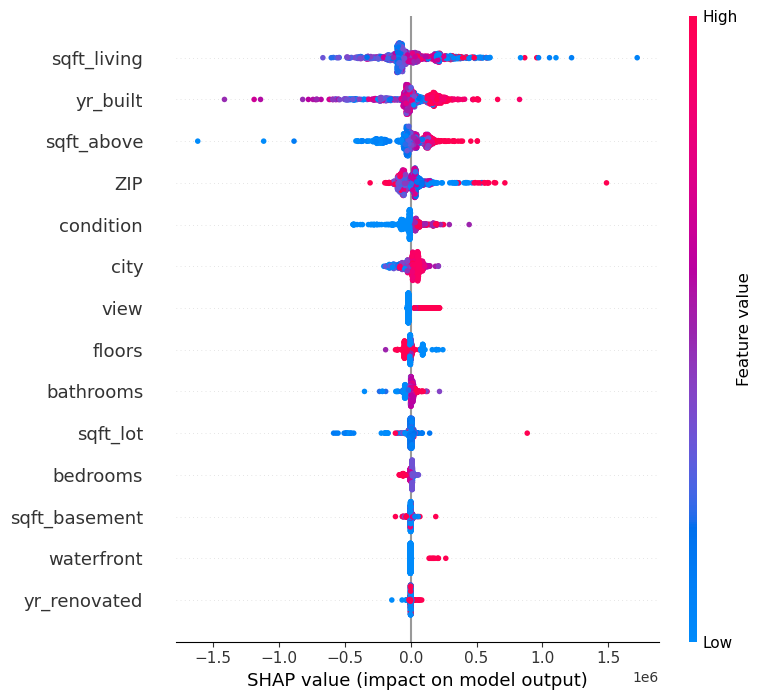

In [70]:
# Apply SHAP to explain model predictions
explainer = shap.Explainer(cat_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)